In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from sklearn.metrics import r2_score
import pickle

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
import copy
from skorch import NeuralNetRegressor
import skorch
# Build resnet from scratch for regression, replacing convolutions and pooling with dense layers
# adapted from https://www.mdpi.com/1099-4300/24/7/876
# adapted from https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample = None):
        super(ResidualBlock, self).__init__()
        self.dense1 = nn.Sequential(
                        nn.Linear(in_channels, out_channels, bias=True),
                        nn.BatchNorm1d(out_channels),
                        nn.ReLU())
        self.dense2 = nn.Sequential(
                        nn.Linear(out_channels, out_channels, bias=True),
                        nn.BatchNorm1d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.dense1(x)
        out = self.dense2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNetRegressor(nn.Module):
    def __init__(self, block, layers, n_inputs=1):
        super(ResNetRegressor, self).__init__()
        self.inplanes = 64
        self.dense1 = nn.Sequential(
                        nn.Linear(n_inputs, 64),
                        nn.BatchNorm1d(64),
                        nn.ReLU())
        #self.maxpool = nn.MaxPool1d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0])
        self.layer1 = self._make_layer(block, 128, layers[1])
        self.layer2 = self._make_layer(block, 256, layers[2])
        self.layer3 = self._make_layer(block, 512, layers[3])
        #self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, 1)
        
    def _make_layer(self, block, planes, blocks):
        downsample = None
        if self.inplanes != planes:   
            downsample = nn.Sequential(
                nn.Linear(self.inplanes, planes),
                nn.BatchNorm1d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.dense1(x)
        #x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        #x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [3]:
prefix = 'transect'
tuneby = 'year'
inPATH = 'results/ml_pred_' + prefix + '_cv_year_tuneby_' + tuneby + '.csv'
with open('results/ml_train_' + prefix + '_cv_year_tuneby_' + tuneby + '_results.pk', 'rb') as f:
    mod_dict = pickle.load(f)
df_bm_pred = pd.read_csv(inPATH)
save_results = True

In [4]:
def r2_corrcoef(y_obs, y_pred):
    corr_matrix = np.corrcoef(y_obs, y_pred)
    corr = corr_matrix[0,1]
    R_sq = corr**2
    return R_sq

In [5]:
df_ens_lin = df_bm_pred[df_bm_pred['Source'].isin(
    ['LASSO', 'PLS', 'PCR'])].groupby(
    [x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]).mean().reset_index()
df_ens_lin['Source'] = 'ENS_LIN'

df_ens_ml = df_bm_pred[df_bm_pred['Source'].isin(
    ['SVR', 'RF', 'GBR'])].groupby(
    [x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]).mean().reset_index()
df_ens_ml['Source'] = 'ENS_ML'

df_ens_both = df_bm_pred[df_bm_pred['Source'].isin(
    ['LASSO', 'PLS', 'PCR', 'SVR', 'RF', 'GBR'])].groupby(
    [x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]).mean().reset_index()
df_ens_both['Source'] = 'ENS_ALL'

In [6]:
df_bm_pred = pd.concat([df_bm_pred, df_ens_lin, df_ens_ml, df_ens_both])

In [7]:
df_bm_pred['Source'] = pd.Categorical(df_bm_pred['Source'], 
                                      categories=['OLS_2022', 'OLS', 
                                                  'LASSO', 'PLS', 'PCR', 
                                                  'SVR', 'RF', 'GBR', 'DNN',
                                                  'ENS_LIN', 'ENS_ML', 'ENS_ALL'])

In [8]:
if 'Transect' in df_bm_pred.columns:
    mae_transect = df_bm_pred.groupby(['Source', 'Year']).apply(
        lambda z: z.groupby(['Pasture', 'Plot', 'Transect', 'Date_mean']).apply(
            lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed']))).mean()).round(2)
    mape_transect = df_bm_pred.groupby(['Source', 'Year']).apply(
        lambda z: z.groupby(['Pasture', 'Plot', 'Transect', 'Date_mean']).apply(
            lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])) / np.mean(x['Observed'])).mean()).round(2)
    r2_transect = df_bm_pred.groupby(['Source', 'Year']).apply((lambda x: r2_score(x['Observed'], x['Predicted']))).round(2)
    r2_corr_transect = df_bm_pred.groupby(['Source', 'Year']).apply((lambda x: r2_corrcoef(x['Observed'], x['Predicted']))).round(2)

In [9]:
if 'Transect' in df_bm_pred.columns:
    df_smry_transect = pd.DataFrame({
        'MAE': mae_transect.unstack(level=0).mean().round(2),
        'MAPE': mape_transect.unstack(level=0).mean().round(2),
        'R^2': r2_transect.unstack(level=0).mean().round(2),
        'r^2': r2_corr_transect.unstack(level=0).mean().round(2)
    })
    display(df_smry_transect)
    if save_results:
        df_smry_transect.to_csv('results/tables/ml_models/ml_yrly_pred_transect_from_' + prefix + '_tuneby_' + tuneby + '.csv')

    df_smry_transect_by_yr = pd.DataFrame({
        'MAE': mae_transect.round(2),
        'MAPE': mape_transect.round(2),
        'R^2': r2_transect.round(2),
        'r^2': r2_corr_transect.round(2)
    })
    display(df_smry_transect_by_yr)
    if save_results:
        df_smry_transect_by_yr.to_csv('results/tables/ml_models/ml_yrly_pred_transect_from_' + prefix + '_tuneby_' + tuneby + '_yearly.csv')

MAE  MAPE   R^2   r^2
Source                            
OLS_2022  264.94  0.33  0.33  0.42
OLS       257.67  0.32  0.37  0.46
LASSO     260.69  0.33  0.36  0.45
PLS       262.59  0.33  0.34  0.43
PCR       261.27  0.33  0.35  0.44
SVR       263.87  0.33  0.36  0.46
RF        273.69  0.36  0.34  0.44
GBR       268.08  0.34  0.32  0.43
DNN       287.63  0.36  0.26  0.40
ENS_LIN   260.14  0.32  0.36  0.45
ENS_ML    263.36  0.34  0.36  0.46
ENS_ALL   260.23  0.33  0.37  0.46

MAE  MAPE   R^2   r^2
Source   Year                          
OLS_2022 2013  231.59  0.38  0.30  0.33
         2014  423.09  0.35  0.25  0.26
         2015  300.83  0.33  0.50  0.55
         2016  294.20  0.27  0.45  0.50
         2017  236.80  0.30  0.48  0.50
...               ...   ...   ...   ...
ENS_ALL  2018  267.15  0.31  0.46  0.54
         2019  207.49  0.23  0.34  0.53
         2020  138.50  0.29  0.42  0.43
         2021  314.16  0.31  0.22  0.48
         2022  211.12  0.49  0.17  0.28

[120 rows x 4 columns]

In [10]:
mae_plot = df_bm_pred.groupby(['Source', 'Year']).apply(
    lambda z: z.groupby(['Pasture', 'Plot', 'Date_mean']).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed']))).mean()).round(2)
mape_plot = df_bm_pred.groupby(['Source', 'Year']).apply(
    lambda z: z.groupby(['Pasture', 'Plot', 'Date_mean']).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])) / np.mean(x['Observed'])).mean()).round(2)
r2_plot = df_bm_pred.groupby(['Source', 'Year', 'Pasture', 'Plot']).mean().reset_index().dropna().groupby(['Source', 'Year']).apply(
    (lambda x: r2_score(x['Observed'], x['Predicted']))).round(2)
r2_corr_plot = df_bm_pred.groupby(['Source', 'Year', 'Pasture', 'Plot']).mean().reset_index().dropna().groupby(['Source', 'Year']).apply(
        lambda x: r2_corrcoef(x['Observed'], x['Predicted'])).round(2)

In [11]:
df_smry_plot = pd.DataFrame({
    'MAE': mae_plot.unstack(level=0).mean().round(2),
    'MAPE': mape_plot.unstack(level=0).mean().round(2),
    'R^2': r2_plot.unstack(level=0).mean().round(2),
    'r^2': r2_corr_plot.unstack(level=0).mean().round(2)
})
display(df_smry_plot)
if save_results:
    df_smry_plot.to_csv('results/tables/ml_models/ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby + '.csv')

df_smry_plot_by_yr = pd.DataFrame({
    'MAE': mae_plot.round(2),
    'MAPE': mape_plot.round(2),
    'R^2': r2_plot.round(2),
    'r^2': r2_corr_plot.round(2)
})
display(df_smry_plot_by_yr)
if save_results:
    df_smry_plot_by_yr.to_csv('results/tables/ml_models/ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby + '_yearly.csv')

MAE  MAPE   R^2   r^2
Source                            
OLS_2022  220.43  0.27  0.46  0.58
OLS       214.38  0.26  0.47  0.62
LASSO     217.87  0.26  0.45  0.61
PLS       221.08  0.27  0.46  0.60
PCR       218.90  0.27  0.47  0.62
SVR       221.96  0.27  0.45  0.62
RF        229.55  0.29  0.46  0.61
GBR       223.80  0.28  0.44  0.61
DNN       246.26  0.29  0.36  0.61
ENS_LIN   218.02  0.26  0.47  0.62
ENS_ML    220.29  0.28  0.47  0.62
ENS_ALL   217.72  0.27  0.47  0.62

MAE  MAPE   R^2   r^2
Source   Year                          
OLS_2022 2013  215.59  0.40  0.61  0.63
         2014  341.58  0.27  0.37  0.42
         2015  236.50  0.25  0.68  0.78
         2016  235.12  0.20  0.34  0.51
         2017  181.44  0.22  0.62  0.69
...               ...   ...   ...   ...
ENS_ALL  2018  220.11  0.24  0.47  0.54
         2019  174.65  0.19  0.30  0.69
         2020  112.87  0.23  0.52  0.57
         2021  277.03  0.26  0.18  0.60
         2022  188.71  0.39  0.57  0.59

[120 rows x 4 columns]

In [12]:
mae_pasture = df_bm_pred.groupby(['Source', 'Year']).apply(
    lambda z: z.groupby(['Pasture', 'Date_mean']).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed']))).mean()).round(2)
mape_pasture = df_bm_pred.groupby(['Source', 'Year']).apply(
    lambda z: z.groupby(['Pasture', 'Date_mean']).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])) / np.mean(x['Observed'])).mean()).round(2)
r2_pasture = df_bm_pred.groupby(['Source', 'Year', 'Pasture']).mean().reset_index().dropna().groupby(['Source', 'Year']).apply(
    lambda x: r2_score(x['Observed'], x['Predicted'])).round(2)
r2_corr_pasture = df_bm_pred.groupby(['Source', 'Year', 'Pasture']).mean().reset_index().dropna().groupby(['Source', 'Year']).apply(
    lambda x: r2_corrcoef(x['Observed'], x['Predicted'])).round(2)

In [13]:
df_smry_pasture = pd.DataFrame({
    'MAE': mae_pasture.unstack(level=0).mean().round(2),
    'MAPE': mape_pasture.unstack(level=0).mean().round(2),
    'R^2': r2_pasture.unstack(level=0).mean().round(2),
    'r^2': r2_corr_pasture.unstack(level=0).mean().round(2)
})
display(df_smry_pasture)
if save_results:
    df_smry_pasture.to_csv('results/tables/ml_models/ml_yrly_pred_pasture_from_' + prefix + '_tuneby_' + tuneby + '.csv')

df_smry_pasture_by_yr = pd.DataFrame({
    'MAE': mae_pasture.round(2),
    'MAPE': mape_pasture.round(2),
    'R^2': r2_pasture.round(2),
    'r^2': r2_corr_pasture.round(2)
})
#display(df_smry_pasture_by_yr)
if save_results:
    df_smry_pasture_by_yr.to_csv('results/tables/ml_models/ml_yrly_pred_pasture_from_' + prefix + '_tuneby_' + tuneby + '_yearly.csv')

MAE  MAPE   R^2   r^2
Source                            
OLS_2022  181.66  0.23  0.43  0.63
OLS       176.64  0.23  0.42  0.67
LASSO     181.07  0.23  0.42  0.66
PLS       183.89  0.23  0.42  0.65
PCR       180.18  0.23  0.45  0.67
SVR       185.74  0.24  0.39  0.65
RF        192.67  0.25  0.37  0.66
GBR       185.50  0.24  0.37  0.65
DNN       207.97  0.26  0.24  0.66
ENS_LIN   180.60  0.23  0.43  0.66
ENS_ML    183.16  0.24  0.41  0.66
ENS_ALL   180.61  0.23  0.42  0.66

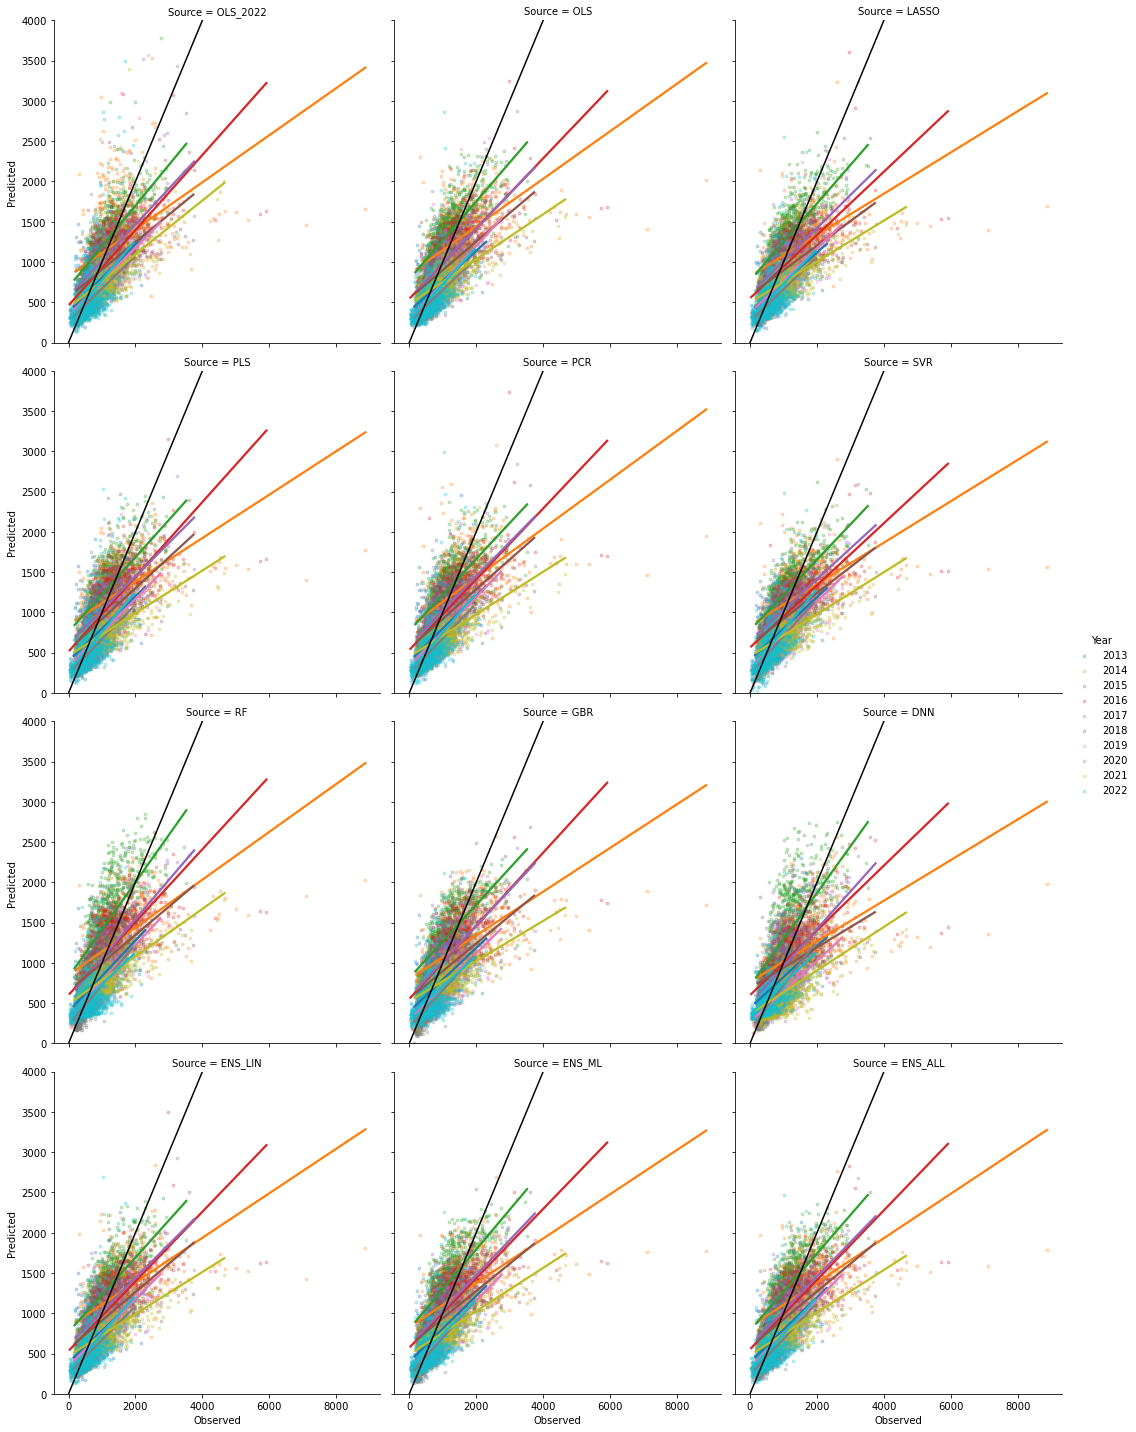

In [14]:
if 'Transect' in df_bm_pred.columns:
    p_trans = sns.lmplot(df_bm_pred, x='Observed', y='Predicted', col='Source', col_wrap=3, hue='Year', ci=None,
                         scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
    for ax in p_trans.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
    if save_results:
        plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_transect_from_' + prefix + '_tuneby_' + tuneby + '.png'), dpi=100)
else:
    p_trans=None

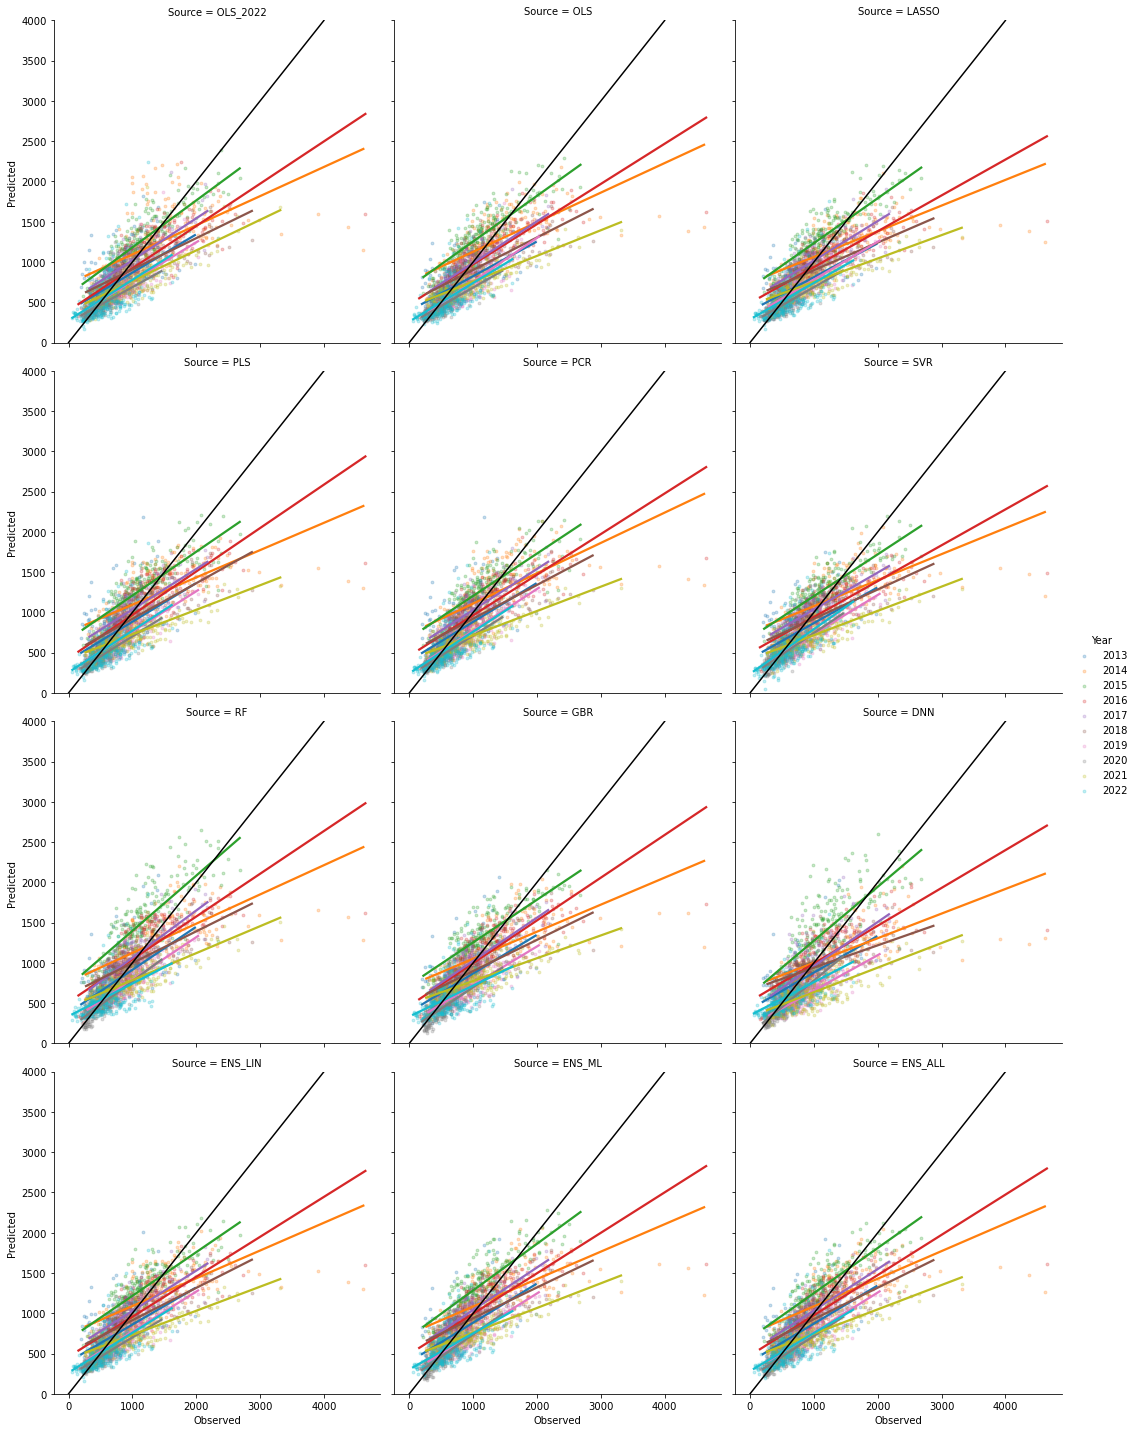

In [15]:
p_plot = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Date_mean']).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', col_wrap=3,
               hue='Year', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby + '.png'), dpi=100)

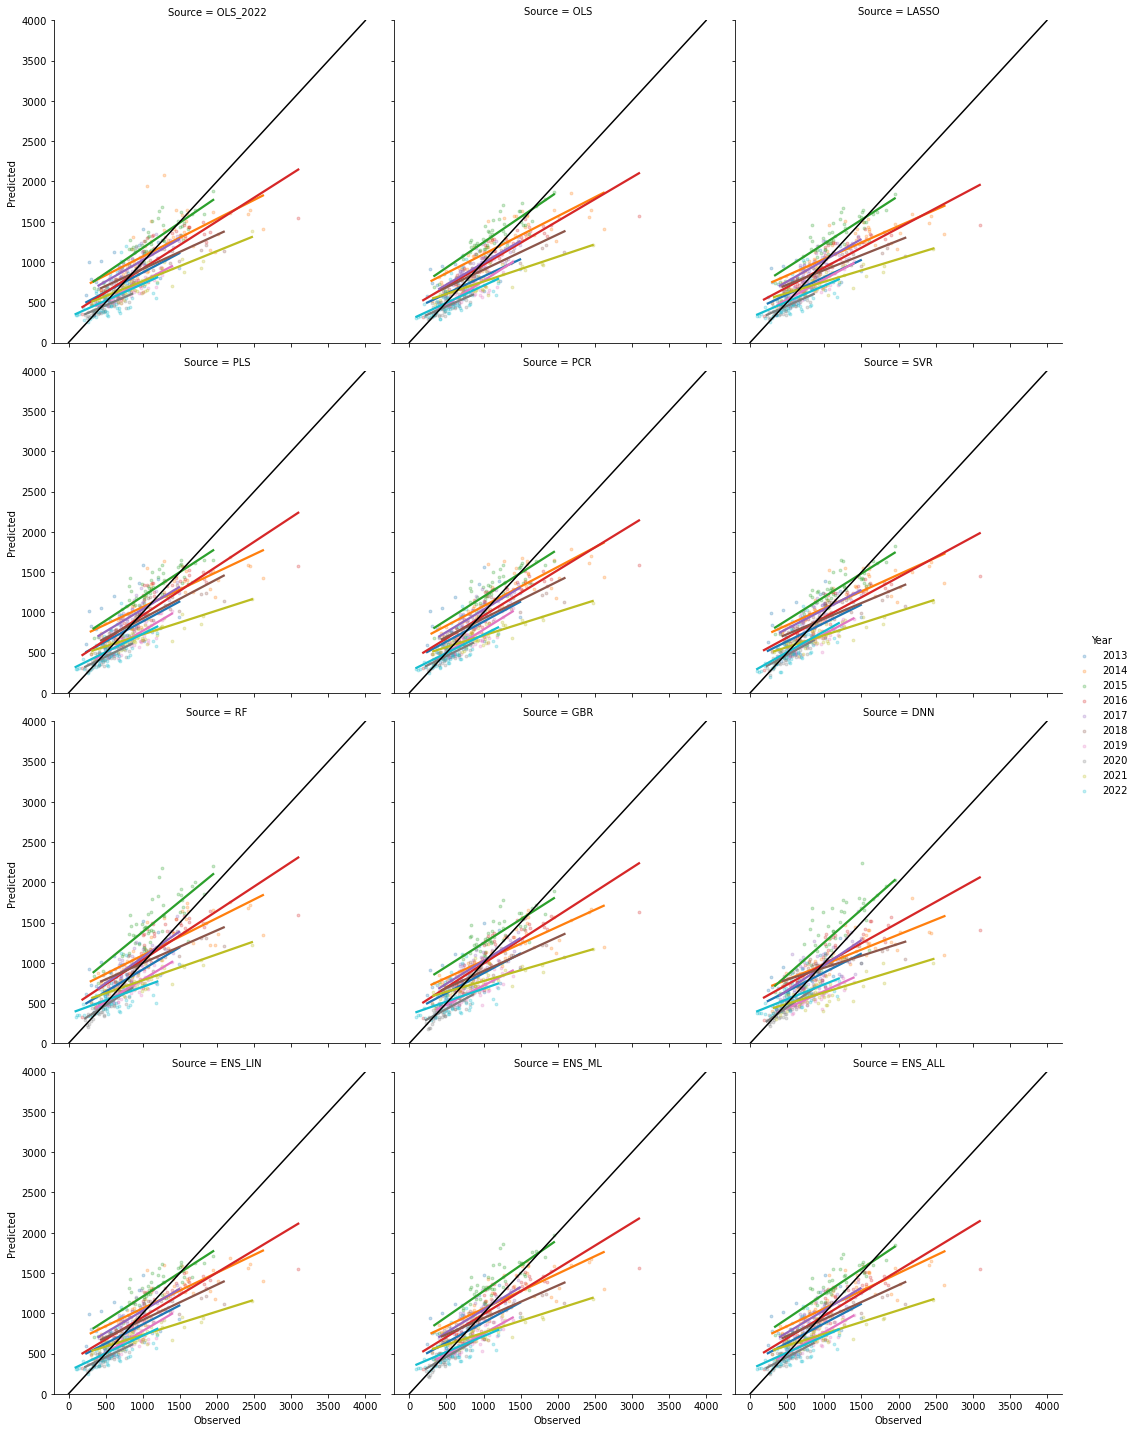

In [16]:
p_pasture = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Date_mean']).mean().reset_index(), 
               x='Observed', y='Predicted', col='Source', col_wrap=3, 
               hue='Year', ci=None, 
                       scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_pasture.axes:
    ax.set_ylim((0, 4000))
    ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_pasture_from_' + prefix + '_tuneby_' + tuneby + '.png'), dpi=100)

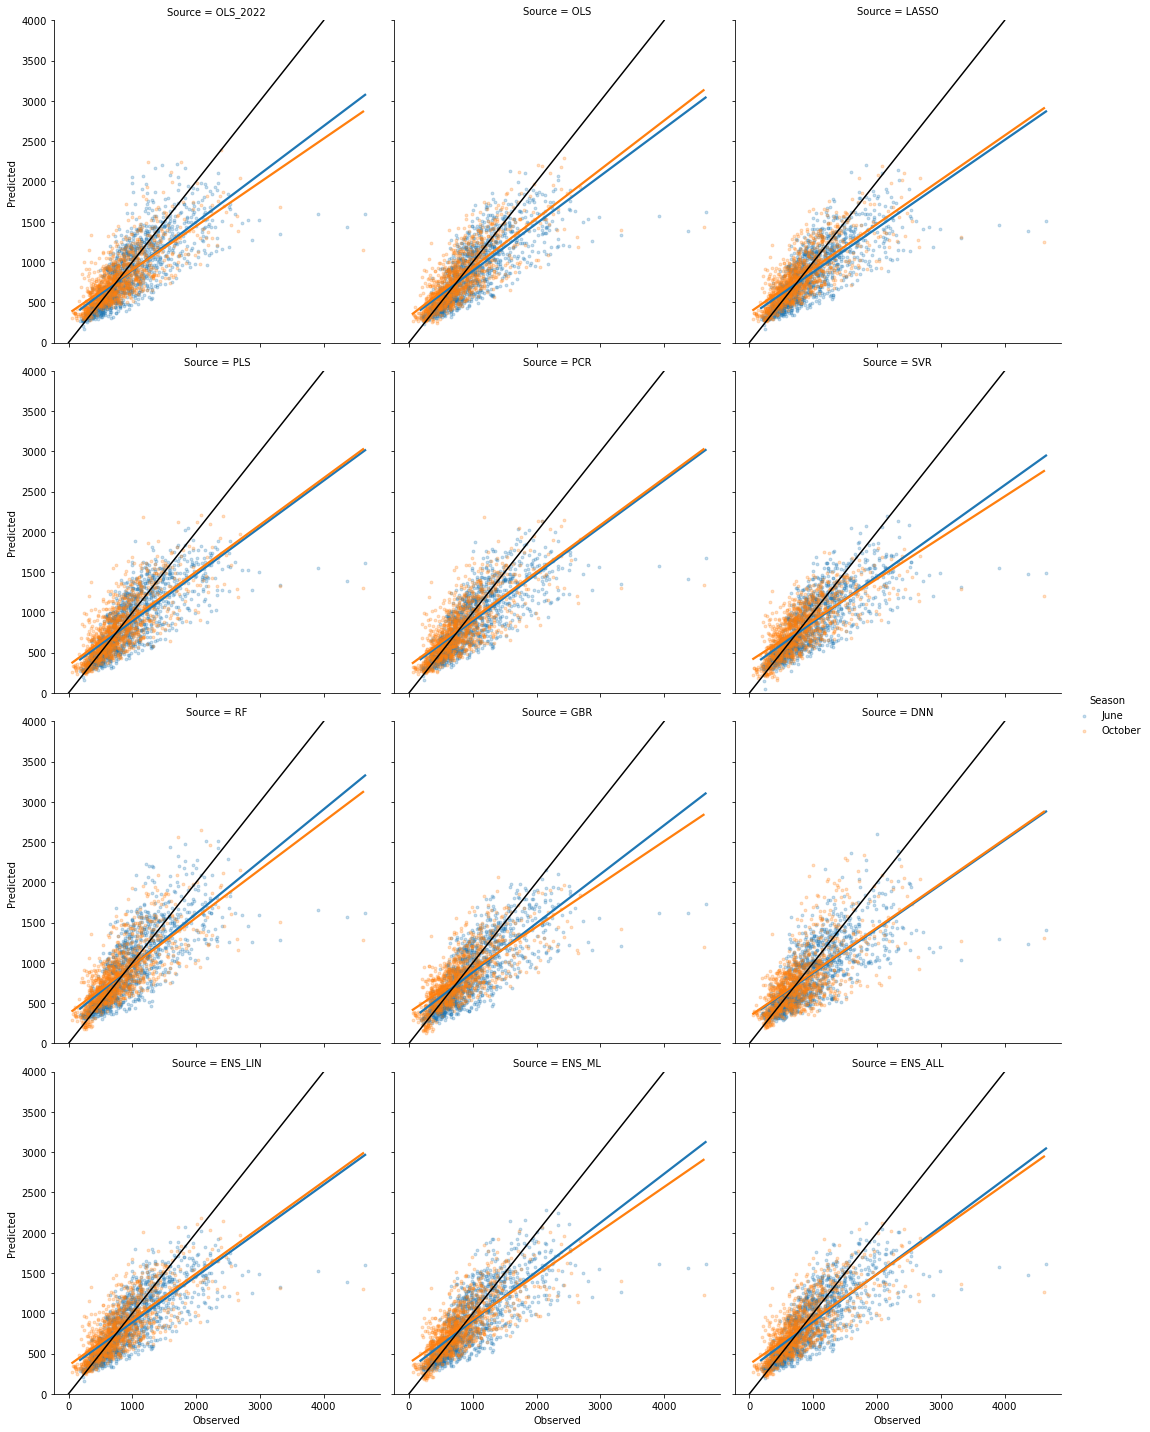

In [17]:
p_plot_seas = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Date_mean', 'Season']).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', col_wrap=3,
               hue='Season', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot_seas.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_plot_by_season_from_' + prefix + '_tuneby_' + tuneby + '.png'), dpi=100)

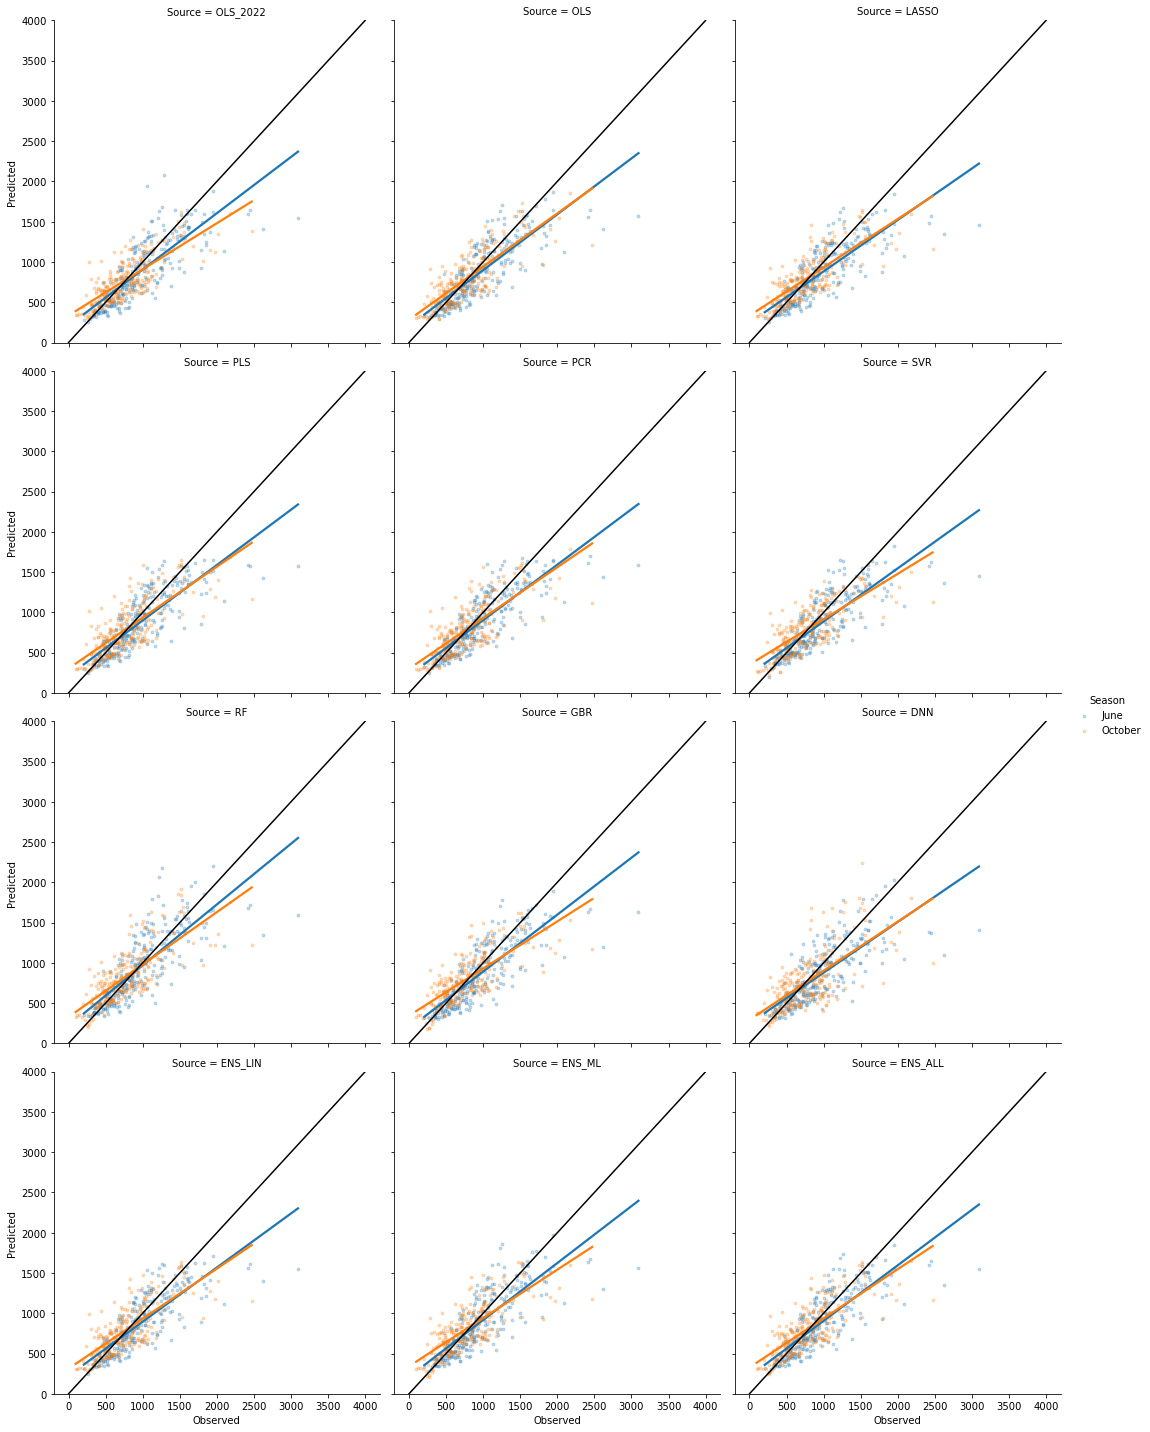

In [18]:
p_pasture_seas = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Date_mean', 'Season']).mean().reset_index(), 
               x='Observed', y='Predicted', col='Source', col_wrap=3, 
               hue='Season', ci=None, 
                       scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_pasture_seas.axes:
    ax.set_ylim((0, 4000))
    ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_pasture_by_season_from_' + prefix + '_tuneby_' + tuneby + '.png'), dpi=100)

In [19]:
df_ols = mod_dict['OLS']['formula_df']

In [20]:
df_ols

year numb_vars                                            formula  R2_adj  \
0   2013         3                                Biomass_kg_ha ~ dfi  0.0848   
0   2013         3                               Biomass_kg_ha ~ ndvi  0.2177   
0   2013         3                               Biomass_kg_ha ~ ndti  0.4834   
0   2013         3                              Biomass_kg_ha ~ satvi  0.2007   
0   2013         3                              Biomass_kg_ha ~ ndii7  0.2186   
..   ...       ...                                                ...     ...   
0   2022         3  Biomass_kg_ha ~ swir2 + bai_236 + bai_346 + sw...  0.5900   
0   2022         3  Biomass_kg_ha ~ bai_126 + bai_136 + bai_246 + ...  0.1731   
0   2022         3  Biomass_kg_ha ~ bai_126 + bai_136 + bai_346 + ...  0.1774   
0   2022         3  Biomass_kg_ha ~ bai_126 + bai_236 + bai_246 + ...  0.1713   
0   2022         3  Biomass_kg_ha ~ bai_126 + bai_236 + bai_346 + ...  0.1768   

           AIC  mae_orig_mean  
0   12970.7611         0.4623  
0   11776.3751         0.4277  
0    8614.1552         0.3388  
0   11937.1180         0.4368  
0   11768.2519         0.4246  
..         ...            ...  
0    5729.6530         0.2984  
0   10746.6789         0.4612  
0   10709.9960         0.4603  
0   10762.3415         0.4621  
0   10715.1433         0.4610  

[16120 rows x 6 columns]

In [21]:
df_ols['features'] = df_ols['formula'].apply(lambda x: [f for f in x.split(' ~ ')[-1].split(' + ') if ':' not in f])

In [22]:
from tqdm import tqdm
"""
Calculated weighted relative variable importance for each variable across model types
"""
# set max vars based on where cross-validated metrics stop improving
max_vars = 3

var_names = list(set(df_ols['features'].sum()))

# Calculate decomposed R^2, relative variable importance (RVI) and AIC weights
df_ols_feats_ptn = pd.DataFrame(columns=['year', 'features', 'formula', 'RVI', 'weight'])
for k in df_ols['year'].unique():
    print(k)
    df_ols_sub_tmp = df_ols[(df_ols['year'] == k) &
    (df_ols['numb_vars'] <= max_vars)].copy()
    min_aic = (df_ols_sub_tmp['AIC']*0.001).min()
    df_ols_sub_tmp['AICw'] = [np.exp(-0.5 * x) for x in (df_ols_sub_tmp['AIC']*0.001 - min_aic)] / \
    np.sum([np.exp(-0.5 * x) for x in (df_ols_sub_tmp['AIC']*0.001 - min_aic)])
    for f in tqdm(var_names):
        df_ols_sub_f = df_ols_sub_tmp[[f in n for n in df_ols_sub_tmp['formula']]]
        if len(df_ols_sub_f) == 0:
            continue
        else:
            for f_form in df_ols_sub_f['formula']:
                f_form_omitted = re.sub(f + ":[^\+]* \+ ", "",
                                        re.sub(" \+ " + f + ":[^\+]*", "",
                                               re.sub(" \+ " + f + ":.+?(?= |$)", "",
                                                      re.sub(" \+(?<=\+)[^\+]*:" + f, "",
                                                             re.sub("\+ " + f + " (?=\+)", "",
                                                                    re.sub("(?<=~ )" + f + " \+ ", "",
                                                                           f_form))))))

                # print(f_form)
                # print(f_form_omitted)
                RVI_tmp = df_ols_sub_tmp['R2_adj'][(df_ols_sub_tmp['formula'] == f_form)].values - \
                          df_ols_sub_tmp['R2_adj'][(df_ols_sub_tmp['formula'] == f_form_omitted)].values
                OVI_tmp = df_ols_sub_tmp['mae_orig_mean'][(df_ols_sub_tmp['formula'] == f_form)].values - \
                          df_ols_sub_tmp['mae_orig_mean'][(df_ols_sub_tmp['formula'] == f_form_omitted)].values
                weight_tmp = df_ols_sub_tmp['AICw'][(df_ols_sub_tmp['formula'] == f_form)].values

                df_ols_feats_tmp = pd.DataFrame(dict(year=k,
                                                     features=f,
                                                     formula=f_form,
                                                     RVI=np.mean(RVI_tmp),
                                                     weight=weight_tmp),
                                                index=[0])
                df_ols_feats_ptn = pd.concat([df_ols_feats_ptn,df_ols_feats_tmp])

2013


100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


2014


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


2015


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


2016


100%|██████████| 28/28 [00:08<00:00,  3.11it/s]


2017


100%|██████████| 28/28 [00:09<00:00,  2.85it/s]


2018


100%|██████████| 28/28 [00:10<00:00,  2.63it/s]


2019


100%|██████████| 28/28 [00:10<00:00,  2.57it/s]


2020


100%|██████████| 28/28 [00:11<00:00,  2.46it/s]


2021


100%|██████████| 28/28 [00:11<00:00,  2.43it/s]


2022


100%|██████████| 28/28 [00:11<00:00,  2.36it/s]


In [23]:
def feature_type(f):
    if f in ['red', 'green', 'blue', 'nir', 'swir1', 'swir2']:
        return 'Band'
    elif 'bai' in f:
        return 'BAI'
    else:
        return 'Veg. Index'

# calculate weighted relative variable importance (RVIw)
df_ols_feats_ptn['RVIw'] = df_ols_feats_ptn['RVI'] * df_ols_feats_ptn['weight']

# add input variable group field
df_ols_feats_ptn['group'] = df_ols_feats_ptn['features'].apply(feature_type)

# calculate sorted mean RVIw for each feature after summing across each kfold
df_ols_feats_grp = df_ols_feats_ptn.groupby(['year',
                                             'features',
                                             'group'])['RVIw'].sum().reset_index()
df_ols_feats_grp['RVIw_mean'] = df_ols_feats_grp.groupby(['features'])['RVIw'].transform('mean')
df_ols_feats_grp = df_ols_feats_grp.sort_values(['RVIw_mean'], ascending=False).reset_index(drop=True)

In [33]:
df_ols_feats_grp['year'] = df_ols_feats_grp['year'].astype('str')
df_ols_feats_grp['year'] = pd.Categorical(df_ols_feats_grp['year'], 
                                          [str(x) for x in range(min(df_ols_feats_grp['year'].astype(int)),
                                                                 max(df_ols_feats_grp['year'].astype(int))+1)])

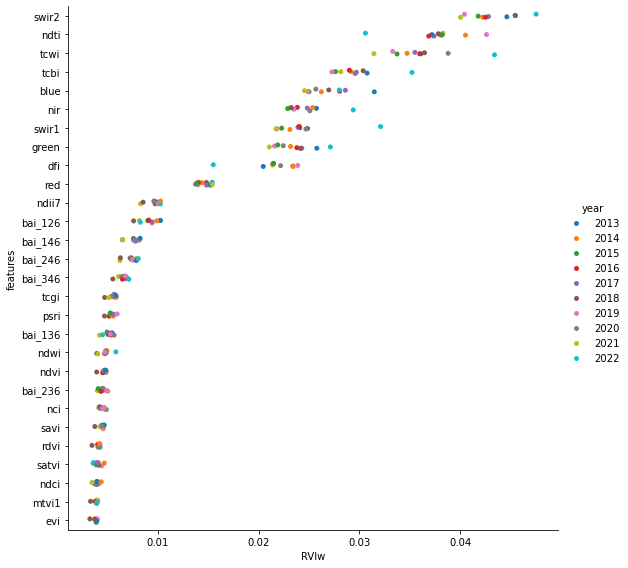

In [34]:
p = sns.catplot(y='features', x='RVIw', hue='year',# hue_order=['Band', 'Veg. Index', 'BAI'],
                orient='h',# palette=sns.color_palette()[6:-1],
                data=df_ols_feats_grp,
                height=8, aspect=1.0)

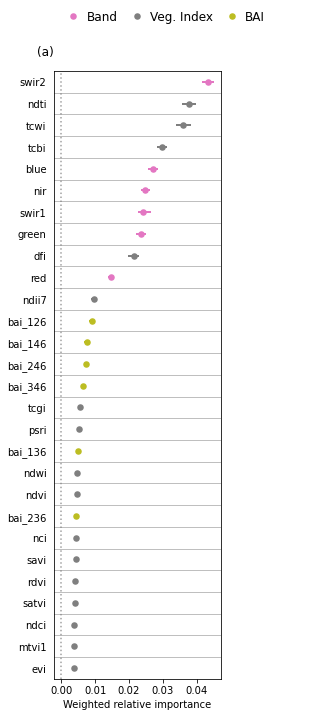

In [24]:
"""
Figure 2: Plot variable importance calculated from all model subsets
"""
font_sml = 10
font_med=12
fig = plt.figure(figsize=(6, 10))
ax1 = fig.add_subplot(1, 2, 1)
pplot1 = sns.pointplot(y='features', x='RVIw', hue='group', hue_order=['Band', 'Veg. Index', 'BAI'],
                       orient='h', dodge=False, ax=ax1, linestyles='None', linewidth=2.0,
                       palette=sns.color_palette()[6:-1],
                       err_kws=dict(linewidth=2.0),
                       data=df_ols_feats_grp)
ax1.set_ylabel('')
ax1.set_xlabel('Weighted relative importance', fontsize=font_sml)
ax1.get_legend().remove()
#ax1.set_xlim((-0.10, 0.50))
ax1.set_yticks(np.arange(0.5, len(df_ols_feats_grp['features'].unique()) - 1, 1), minor=True)
ax1.grid(which='minor', axis='y')
for tic in ax1.yaxis.get_major_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)
for tic in ax1.yaxis.get_minor_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)
ax1.axvline(x=0, color='grey', alpha=0.75, linestyle='dotted')
ax1.tick_params(axis='x', which='major', labelsize=font_sml)
ax1.tick_params(axis='y', which='major', labelsize=font_sml)
ax1.text(x=-0.1, y=1.025, s='(a)', transform=ax1.transAxes, size=font_med)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), fontsize=font_med,
           columnspacing=0.6, handletextpad=0.1, frameon=False)
plt.tight_layout(w_pad=3.0, rect=(0, 0, 1, 0.95))
if save_results:
    plt.savefig(outDIR_figs + mod_dir_dict[mod_type] + mod_type + '_variable_importance.png', dpi=600,
                bbox_inches='tight', pad_inches=0.2)
    plt.close()

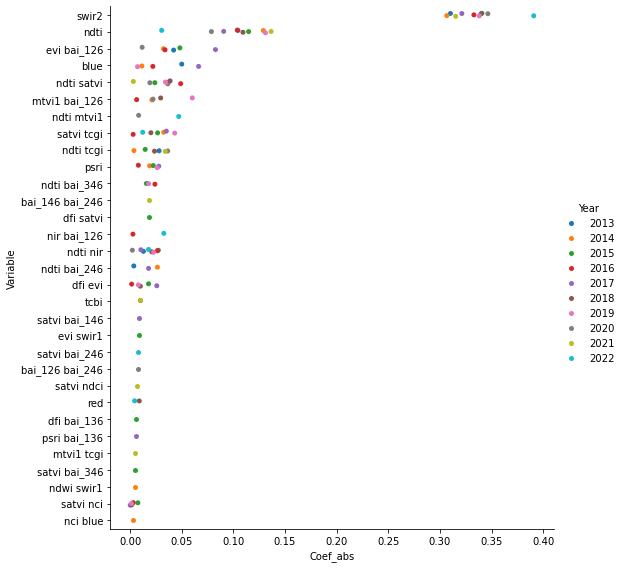

In [35]:
df_lasso_coefs = mod_dict['LASSO']['variable_df']
df_lasso_coefs['Coef_abs'] = abs(df_lasso_coefs['Coef'])
df_lasso_coefs_ranked = df_lasso_coefs.groupby('Variable')['Coef_abs'].mean().sort_values(ascending=False)
df_lasso_coefs['Variable'] = pd.Categorical(df_lasso_coefs['Variable'], categories=df_lasso_coefs_ranked.index.values)
p = sns.catplot(df_lasso_coefs, x='Coef_abs', y='Variable', hue='Year', height=8, aspect=1.0, orient='h')
#for ax in p.axes.flatten():
#    ax.tick_params(axis='x', rotation=90)

In [36]:
df_lasso_coefs.groupby('Variable')['Coef'].count().sort_values(ascending=False)

Variable
swir2              10
ndti               10
ndti satvi          9
ndti nir            8
satvi tcgi          7
evi bai_126         6
ndti tcgi           6
blue                5
mtvi1 bai_126       5
satvi nci           5
psri                5
dfi evi             5
ndti bai_246        3
ndti bai_346        3
nir bai_126         2
red                 2
ndti mtvi1          2
tcbi                2
ndwi swir1          1
satvi bai_346       1
mtvi1 tcgi          1
psri bai_136        1
dfi bai_136         1
satvi ndci          1
dfi satvi           1
bai_126 bai_246     1
satvi bai_246       1
evi swir1           1
satvi bai_146       1
bai_146 bai_246     1
nci blue            1
Name: Coef, dtype: int64

In [37]:
df_lasso_coefs.groupby('Year')['Coef'].count()

Year
2013     8
2014    12
2015    15
2016    13
2017    13
2018    11
2019    11
2020     9
2021     8
2022     8
Name: Coef, dtype: int64

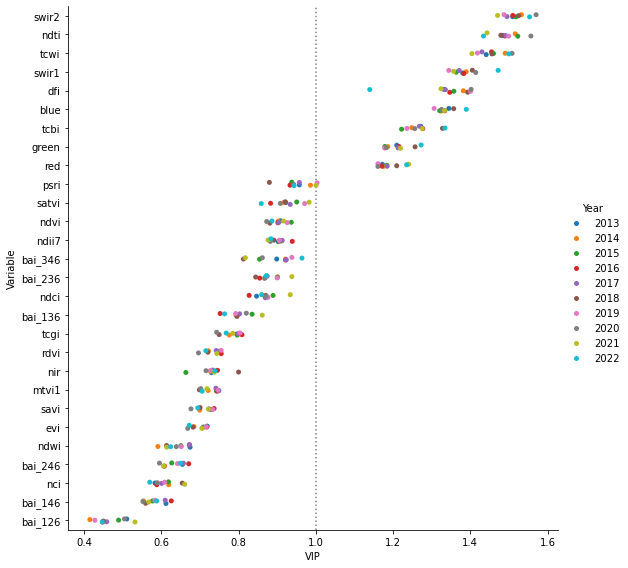

In [46]:
df_vip = mod_dict['PLS']['variable_df']
df_vip_ranked = df_vip.groupby('Variable')['VIP'].mean().sort_values(ascending=False)
df_vip['Variable'] = pd.Categorical(df_vip['Variable'], categories=df_vip_ranked.index.values)
df_vip_top = df_vip[df_vip['VIP'] > 1.0].copy()
df_vip_top['Variable'] = df_vip_top['Variable'].cat.remove_unused_categories()
p = sns.catplot(df_vip, x='VIP', y='Variable',  hue='Year', height=8, aspect=1.0, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')

In [47]:
df_vip[df_vip['VIP'] > 1.0].groupby('Variable')['VIP'].count().sort_values(ascending=False)

Variable
swir2      10
ndti       10
tcwi       10
swir1      10
dfi        10
blue       10
tcbi       10
green      10
red        10
psri        2
bai_146     0
nci         0
bai_246     0
ndwi        0
nir         0
evi         0
savi        0
mtvi1       0
bai_236     0
rdvi        0
tcgi        0
bai_136     0
ndci        0
bai_346     0
ndii7       0
ndvi        0
satvi       0
bai_126     0
Name: VIP, dtype: int64

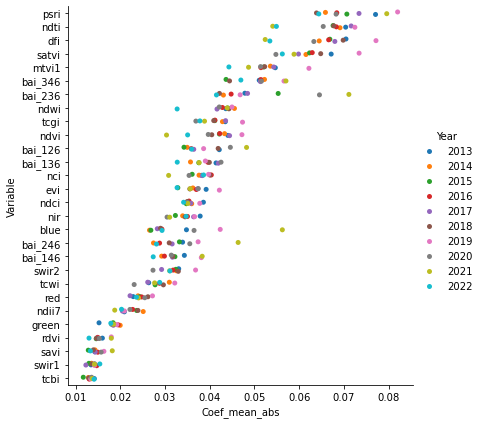

In [48]:
df_pcr_coefs = mod_dict['PCR']['variable_df']
pcr_coefs_abs_mean = df_pcr_coefs.groupby(['Year', 'Variable']).apply(lambda x: np.mean(np.abs(x), axis=1))
pcr_coefs_abs_mean.name = 'Coef_mean_abs'
df_pcr_coefs_mean = pcr_coefs_abs_mean.reset_index()

pcr_vars_mean_ranked = df_pcr_coefs_mean.groupby('Variable')['Coef_mean_abs'].mean().sort_values(ascending=False)
df_pcr_coefs_mean['Variable'] = pd.Categorical(df_pcr_coefs_mean['Variable'], categories=pcr_vars_mean_ranked.index.values)

df_pcr_coefs_mean_top20 = df_pcr_coefs_mean[df_pcr_coefs_mean['Variable'].isin(pcr_vars_mean_ranked.head(20).index.values)].copy()
df_pcr_coefs_mean_top20['Variable'] = df_pcr_coefs_mean_top20['Variable'].cat.remove_unused_categories()

p = sns.catplot(df_pcr_coefs_mean,
                x='Coef_mean_abs', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

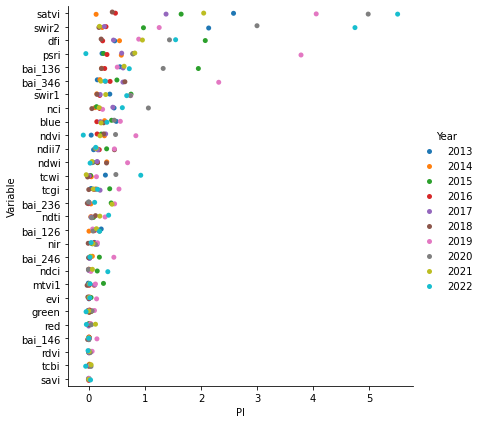

In [49]:
df_svr_pi = mod_dict['SVR']['variable_df']
df_svr_pi_ranked = df_svr_pi.groupby('Variable')['PI'].mean().sort_values(ascending=False)
df_svr_pi['Variable'] = pd.Categorical(df_svr_pi['Variable'], categories=df_svr_pi_ranked.index.values)
p = sns.catplot(df_svr_pi,
                x='PI', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

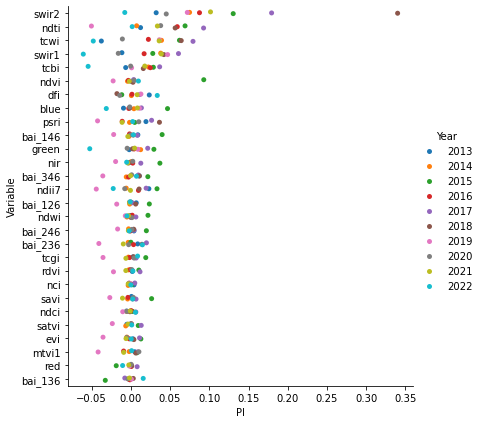

In [50]:
df_rf_pi = mod_dict['RF']['variable_df']
df_rf_pi_ranked = df_rf_pi.groupby('Variable')['PI'].mean().sort_values(ascending=False)
df_rf_pi['Variable'] = pd.Categorical(df_rf_pi['Variable'], categories=df_rf_pi_ranked.index.values)
p = sns.catplot(df_rf_pi,
                x='PI', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

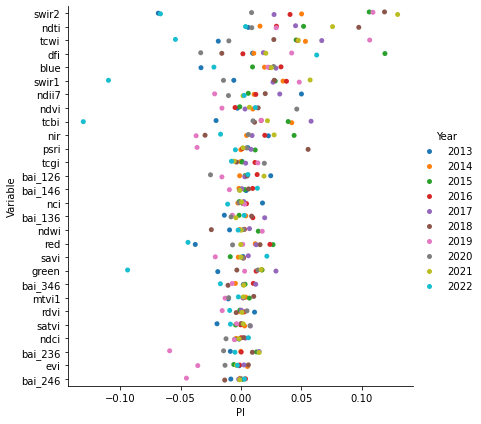

In [51]:
df_gbr_pi = mod_dict['GBR']['variable_df']
df_gbr_pi_ranked = df_gbr_pi.groupby('Variable')['PI'].mean().sort_values(ascending=False)
df_gbr_pi['Variable'] = pd.Categorical(df_gbr_pi['Variable'], categories=df_gbr_pi_ranked.index.values)
p = sns.catplot(df_gbr_pi,
                x='PI', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

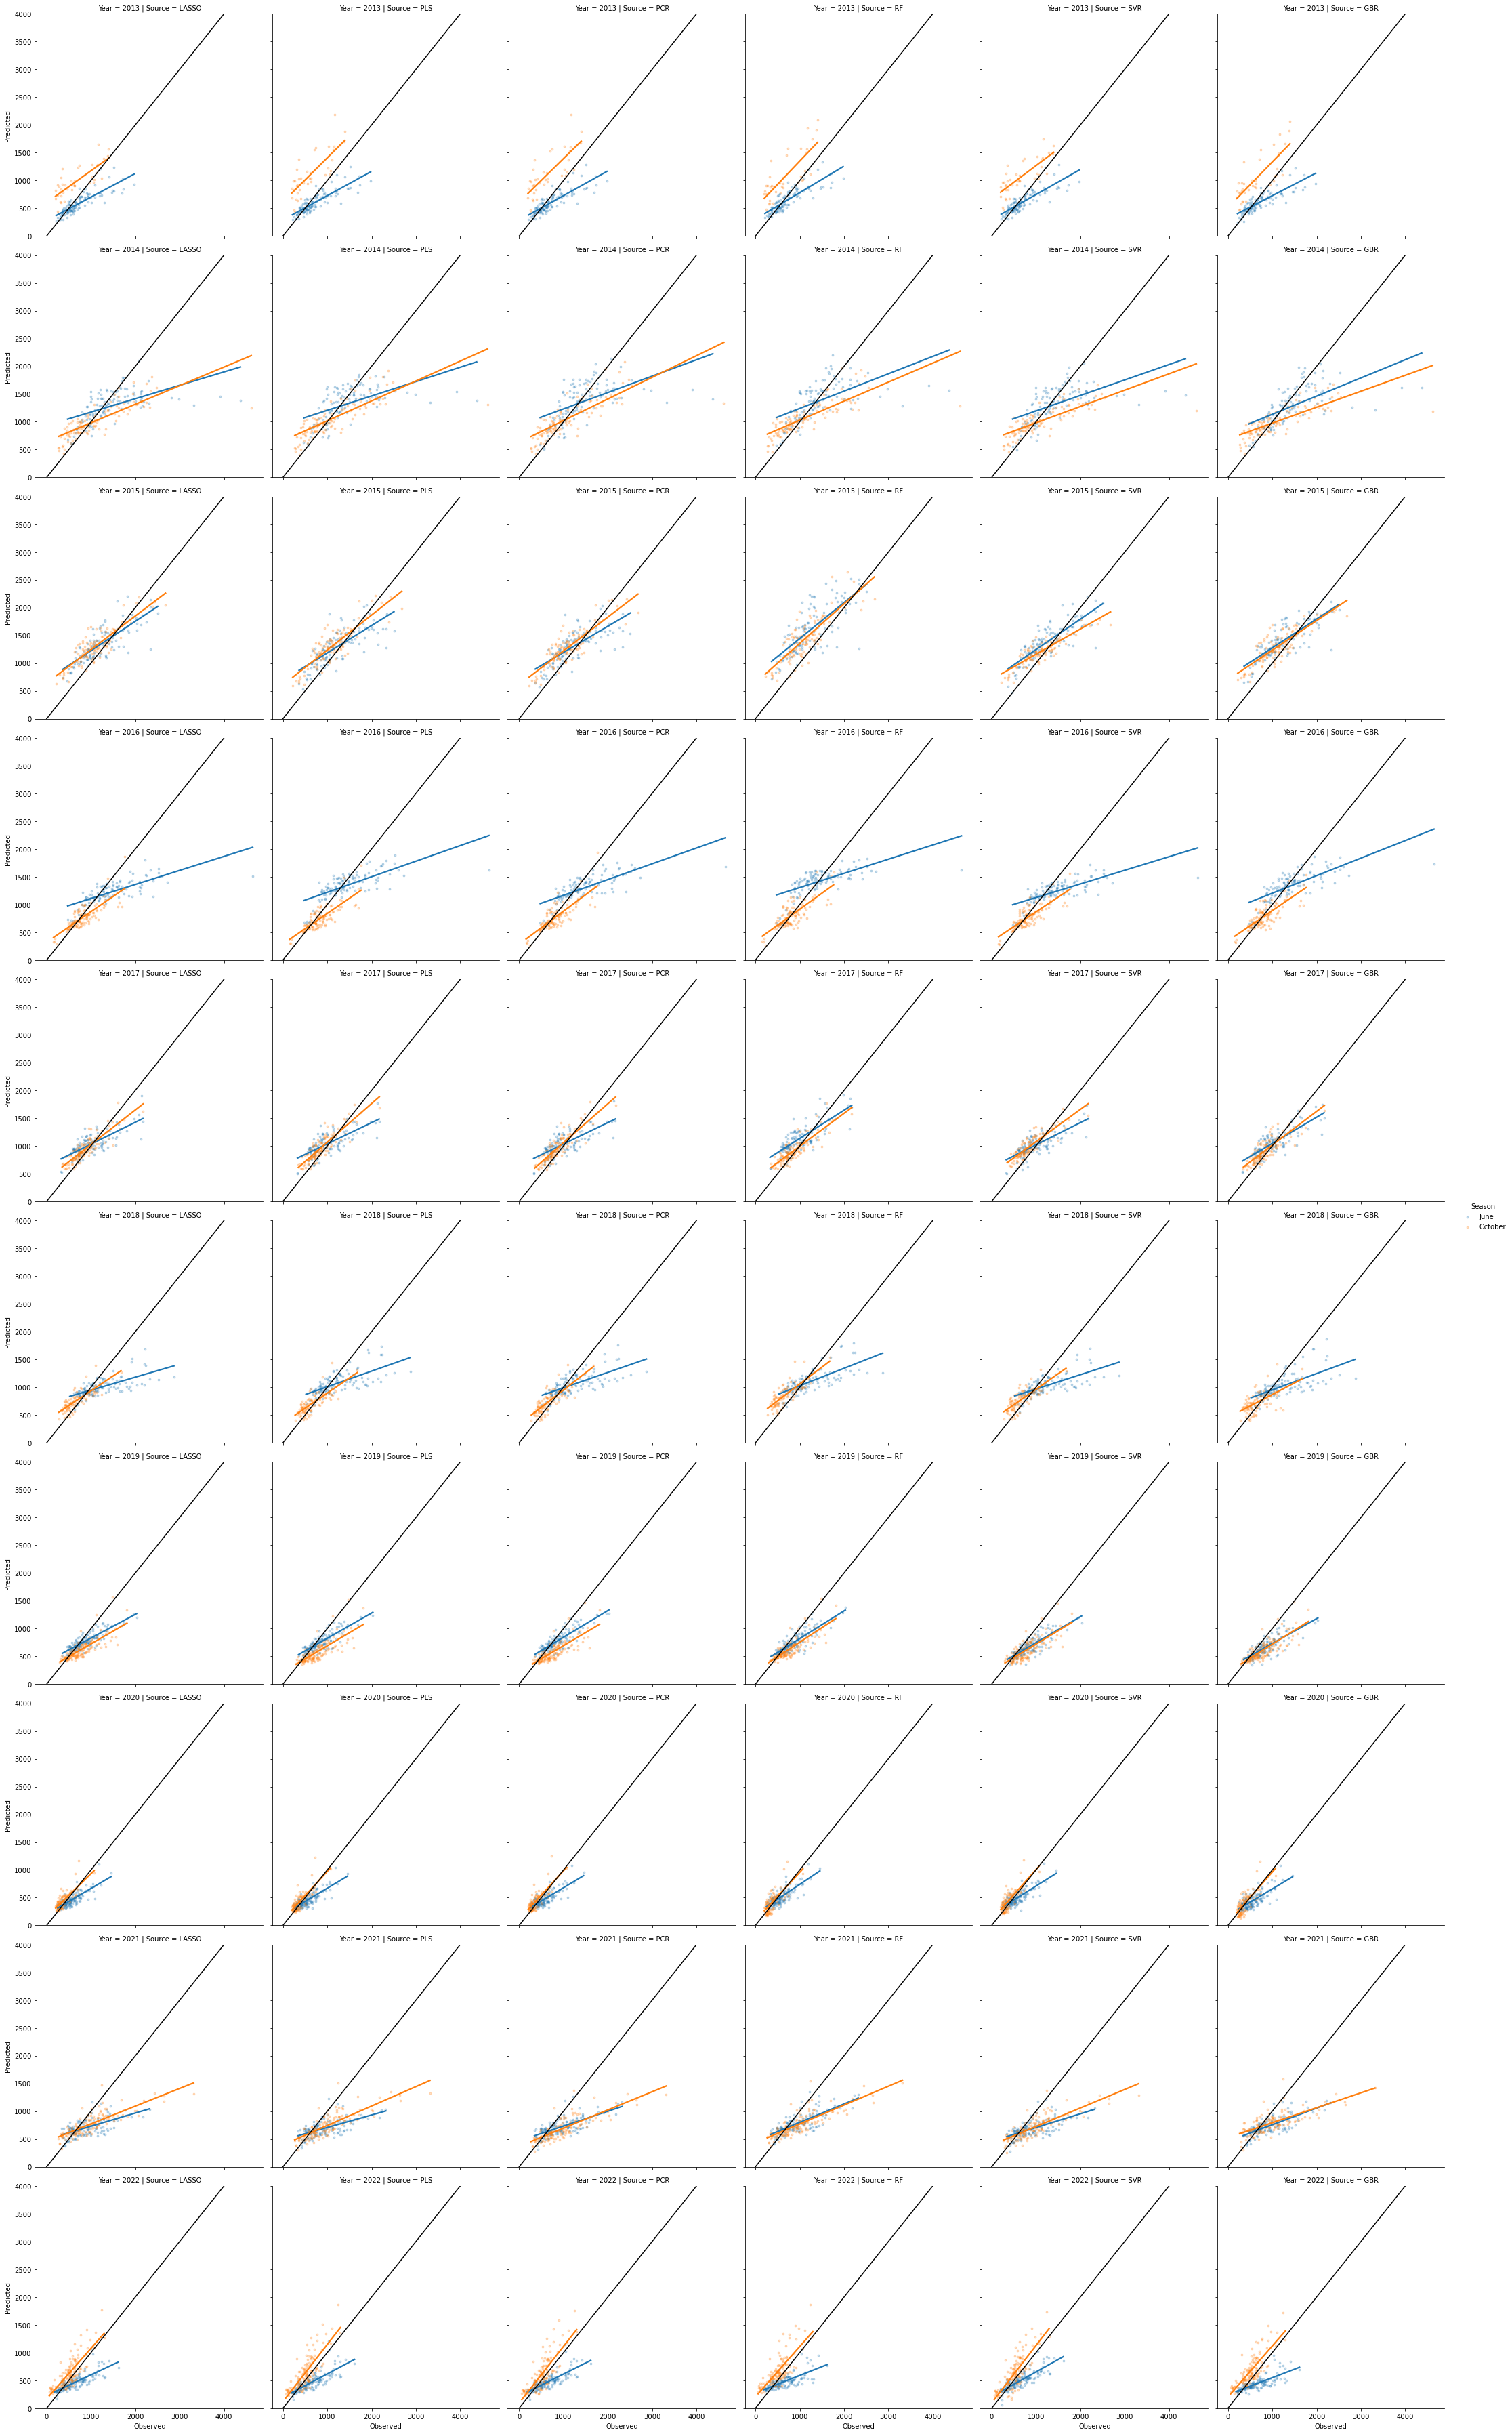

In [52]:
p_plot_seas = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Season']).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', row='Year', col_order=['LASSO', 'PLS', 'PCR', 'RF', 'SVR', 'GBR'],
               hue='Season', ci=None, order=1,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot_seas.axes.flatten():
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')

In [54]:
param_dfs = {}
for k in mod_dict:
    if 'tune_results' in mod_dict[k].keys():
        for idx, yr in enumerate(mod_dict[k]['tune_results']):
            if idx == 0:
                param_names = list(np.unique([list(x.keys()) for x in mod_dict[k]['tune_results'][yr]['params']]))
                param_dfs[k] = pd.DataFrame(columns=['Model', 'Year', 'Best', 'MAPE', 'MSE', 'R2', 'R2_train'] + param_names)
            df_tmp = pd.DataFrame({'Model': k,
                                   'Year': str(yr),
                                   'Best': 0,
                                   'MAPE': mod_dict[k]['tune_results'][yr]['mean_test_MAPE'],
                                   'MSE': mod_dict[k]['tune_results'][yr]['mean_test_MSE'],
                                   'R2': mod_dict[k]['tune_results'][yr]['mean_test_R2'],
                                   'R2_train': mod_dict[k]['tune_results'][yr]['mean_train_R2']})
            for p in param_names:
                df_tmp[p] = mod_dict[k]['tune_results'][yr]['param_' + p].data
            idx_best = mod_dict[k]['tune_results'][yr]['rank_test_MAPE'].argmin()
            df_tmp.loc[idx_best, 'Best'] = 1
            param_dfs[k] = pd.concat([param_dfs[k], df_tmp])
        if k in param_dfs.keys():
            param_dfs[k] = param_dfs[k].reset_index(drop=True)

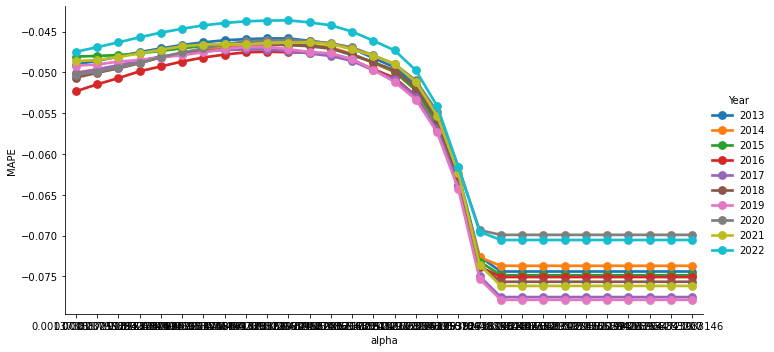

In [55]:
sns.catplot(x='alpha', y='MAPE', data=param_dfs['LASSO'], hue='Year', kind='point', aspect=2)

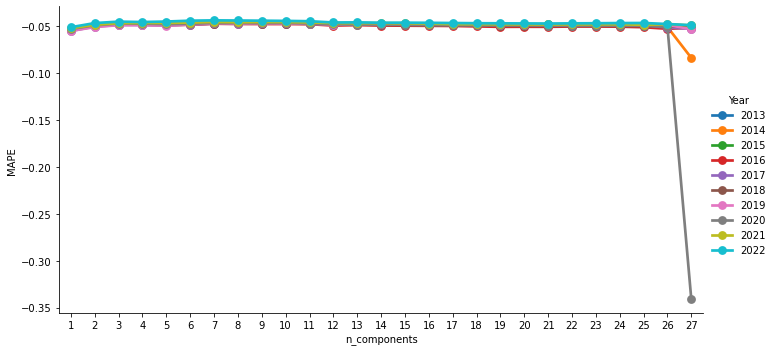

In [56]:
sns.catplot(x='n_components', y='MAPE', data=param_dfs['PLS'], hue='Year', kind='point', aspect=2)

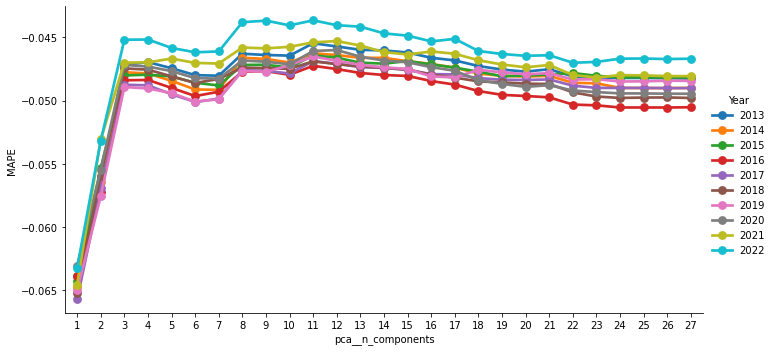

In [57]:
sns.catplot(x='pca__n_components', y='MAPE', data=param_dfs['PCR'], hue='Year', kind='point', aspect=2)

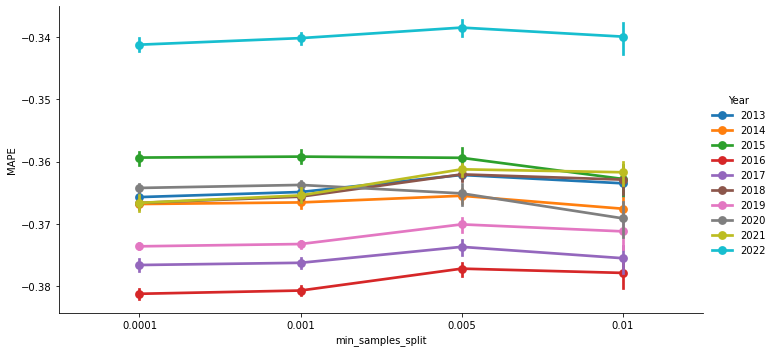

In [58]:
sns.catplot(x='min_samples_split', y='MAPE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

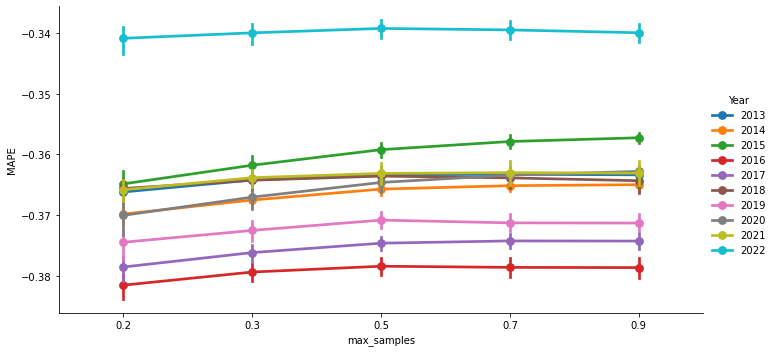

In [59]:
sns.catplot(x='max_samples', y='MAPE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

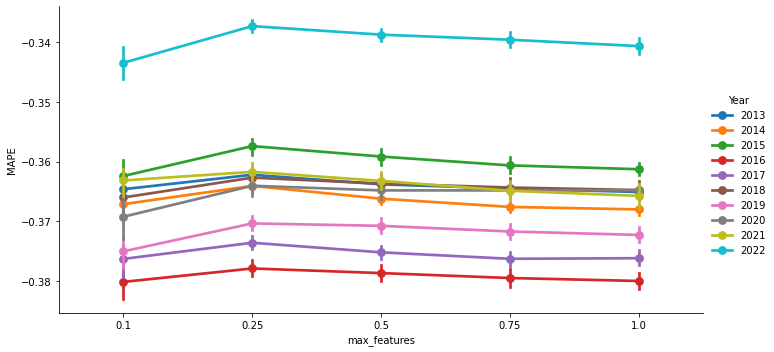

In [63]:
sns.catplot(x='max_features', y='MAPE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

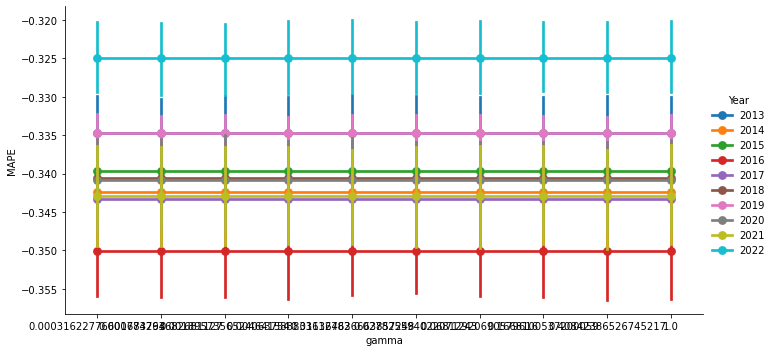

In [64]:
sns.catplot(x='gamma', y='MAPE', data=param_dfs['SVR'], hue='Year', kind='point', aspect=2)

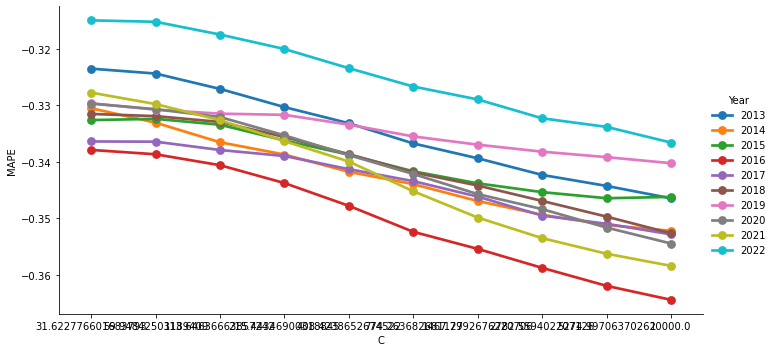

In [65]:
sns.catplot(x='C', y='MAPE', data=param_dfs['SVR'], hue='Year', kind='point', aspect=2)

In [78]:
np.logspace(0.5, 4, 15, base=10)

array([3.16227766e+00, 5.62341325e+00, 1.00000000e+01, 1.77827941e+01,
       3.16227766e+01, 5.62341325e+01, 1.00000000e+02, 1.77827941e+02,
       3.16227766e+02, 5.62341325e+02, 1.00000000e+03, 1.77827941e+03,
       3.16227766e+03, 5.62341325e+03, 1.00000000e+04])

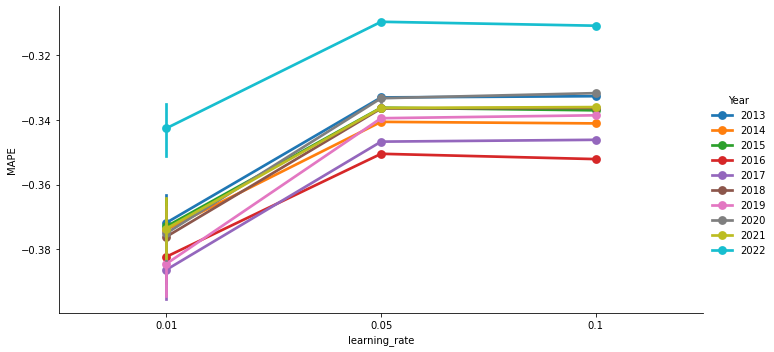

In [67]:
sns.catplot(x='learning_rate', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)

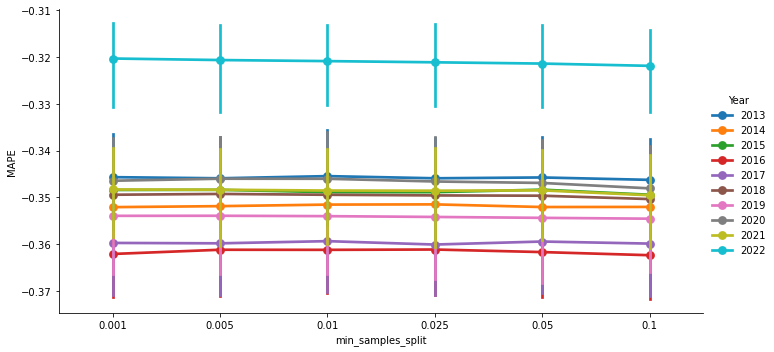

In [68]:
sns.catplot(x='min_samples_split', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)

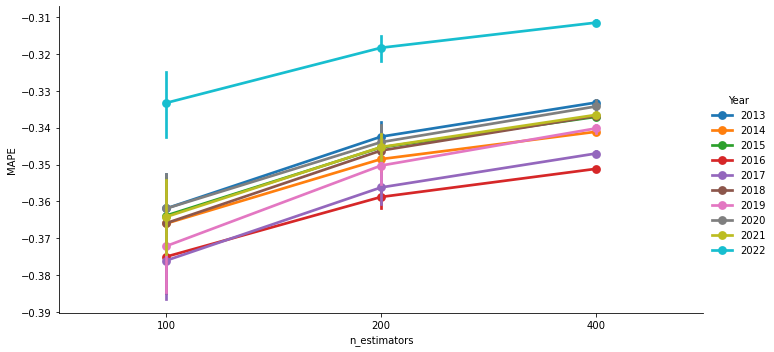

In [69]:
sns.catplot(x='n_estimators', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)

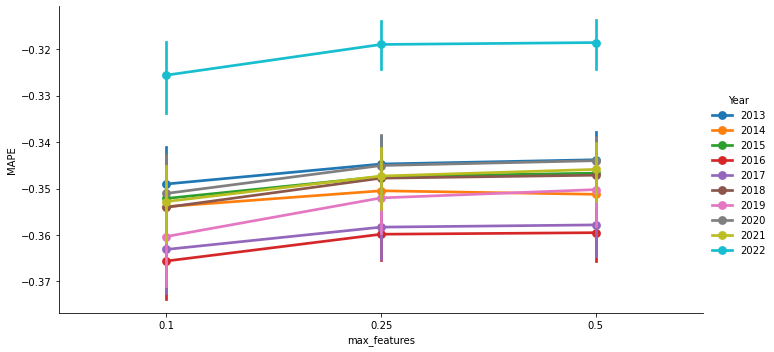

In [70]:
sns.catplot(x='max_features', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)

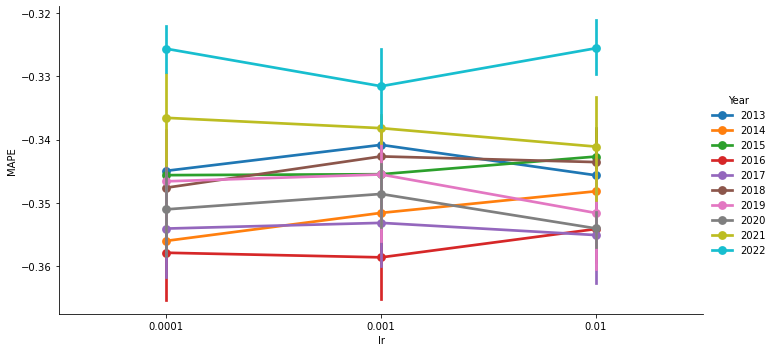

In [71]:
sns.catplot(x='lr', y='MAPE', data=param_dfs['DNN'], hue='Year', kind='point', aspect=2)

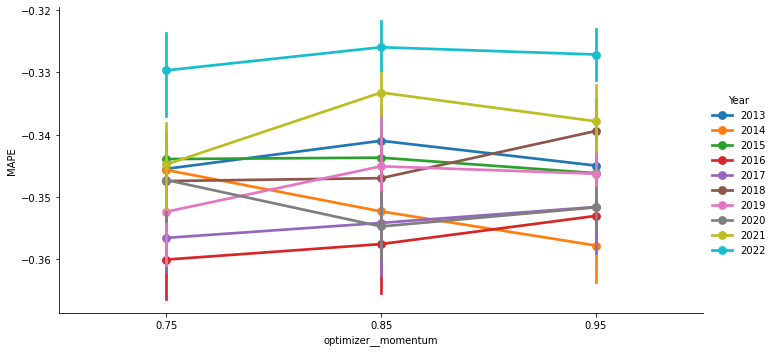

In [72]:
sns.catplot(x='optimizer__momentum', y='MAPE', data=param_dfs['DNN'], hue='Year', kind='point', aspect=2)

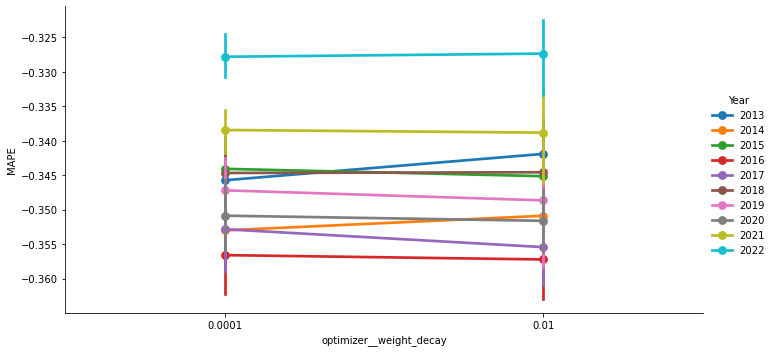

In [73]:
sns.catplot(x='optimizer__weight_decay', y='MAPE', data=param_dfs['DNN'], hue='Year', kind='point', aspect=2)

In [74]:
param_dfs['DNN'][param_dfs['DNN']['Best'] == 1].sort_values('lr')
#mod_dict['DNN2']

Model  Year Best      MAPE            MSE        R2  R2_train batch_size  \
66    DNN  2016    1 -0.341767 -175299.203993  0.263147  0.585890        256   
87    DNN  2017    1 -0.343770 -184227.025174  0.255512  0.614202        256   
122   DNN  2019    1 -0.330350 -188772.227865  0.296341  0.601351        256   
160   DNN  2021    1 -0.325282 -167117.608941  0.298736  0.620690        256   
44    DNN  2015    1 -0.333552 -157464.063802  0.350457  0.610205        256   
100   DNN  2018    1 -0.330996 -177538.365451  0.289776  0.617062        256   
133   DNN  2020    1 -0.338754 -185984.431424  0.288043  0.548750        256   
2     DNN  2013    1 -0.331112 -175290.445095  0.334141  0.578306        256   
19    DNN  2014    1 -0.334836 -134663.024957  0.347174  0.599197        256   
165   DNN  2022    1 -0.318835 -180357.713542  0.318151  0.580740        256   

         lr max_epochs                     module__block module__layers  \
66   0.0001        100  <class '__main__.ResidualBlock'>   [3, 4, 6, 3]   
87   0.0001        100  <class '__main__.ResidualBlock'>   [3, 4, 6, 3]   
122  0.0001        100  <class '__main__.ResidualBlock'>   [3, 4, 6, 3]   
160  0.0001        100  <class '__main__.ResidualBlock'>   [3, 4, 6, 3]   
44    0.001        100  <class '__main__.ResidualBlock'>   [3, 4, 6, 3]   
100   0.001        100  <class '__main__.ResidualBlock'>   [3, 4, 6, 3]   
133   0.001        100  <class '__main__.ResidualBlock'>   [3, 4, 6, 3]   
2      0.01        100  <class '__main__.ResidualBlock'>   [3, 4, 6, 3]   
19     0.01        100  <class '__main__.ResidualBlock'>   [3, 4, 6, 3]   
165    0.01        100  <class '__main__.ResidualBlock'>   [3, 4, 6, 3]   

    module__n_inputs optimizer__momentum optimizer__nesterov  \
66                28                0.75                True   
87                28                0.85                True   
122               28                0.85                True   
160               28                0.95                True   
44                28                0.85                True   
100               28                0.95                True   
133               28                0.75                True   
2                 28                0.85                True   
19                28                0.75                True   
165               28                0.85                True   

    optimizer__weight_decay  
66                     0.01  
87                   0.0001  
122                    0.01  
160                    0.01  
44                     0.01  
100                    0.01  
133                  0.0001  
2                      0.01  
19                   0.0001  
165                  0.0001